# **Housing Cost Regression**

Name: Muhammad Fitri Amir bin Abdullah

Admin Number: P2222811

Class: DAAA/FT/2A/06
<hr>

## Objective
> To build a regression machine learning model to predict the prices of housing.<br>

**How is the prediction task defined?**
> Given a dataset with prices of renovation across different US cities, the prediction task wants us to predict the price of houses based of the different properties of a house given to us such as number of toilets, rooms, floors as well as the sqm of the house. The output variable (or target feature) is Price, which is a continuous variable. Hence, this most likely requires a regression model.

## Importing Datasets/Libraries

In [374]:
#Importing the libraries and the dataset

# Basic libs
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso ,SGDRegressor ,ElasticNet ,BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR ,SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_validate

df = pd.read_csv('../ST1511 AIML-CA1-datasets/housing_dataset.csv')

## **Exploratory Data Analysis**

<font size = 5> 

**Initial Summary** 
<br>


<font size = 4>

From the initial data summary, we can see that there are no null values in the original data set given to us. There are 8 columns, 545 datapoints and there are 5 integer columns, 2 object columns and 1 float column. One of the integer columns, `Price`, is our target feature.<br>

As there are 2 object columns, I will consider using an encoder to change the data type before putting them into use. Finally, we can also see that every column has more than one type of data therefore all the columns can be used in training the model.

In [375]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   House Area (sqm)   545 non-null    float64
 3   No. of Bedrooms    545 non-null    int64  
 4   No. of Toilets     545 non-null    int64  
 5   Stories            545 non-null    int64  
 6   Renovation Status  545 non-null    object 
 7   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000


In [376]:
df.isnull().sum()

House ID             0
City                 0
House Area (sqm)     0
No. of Bedrooms      0
No. of Toilets       0
Stories              0
Renovation Status    0
Price ($)            0
dtype: int64

In [377]:
df.nunique().sort_values()

Renovation Status      3
No. of Toilets         4
Stories                4
City                   5
No. of Bedrooms        6
Price ($)            219
House Area (sqm)     284
House ID             545
dtype: int64

Before I start my visualisation, I will first drop house ID as it is a unique identifier and will not help in training the model.

In [378]:
house_df = df.drop(['House ID'], axis=1)
house_df.head()

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,1330000
1,Denver,896.0,4,4,4,furnished,1225000
2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,Seattle,750.0,4,2,2,furnished,1221500
4,New York,742.0,4,1,2,furnished,1141000


In [379]:
#To find unique values in categorical columns

for col in house_df.columns:
    if house_df[col].dtype == 'object':
        print(col, ': ', house_df[col].unique())
        print(house_df[col].value_counts())

City :  ['Chicago' 'Denver' 'Seattle' 'New York' 'Boston']
New York    158
Seattle     134
Boston      105
Denver       89
Chicago      59
Name: City, dtype: int64
Renovation Status :  ['furnished' 'semi-furnished' 'unfurnished']
semi-furnished    227
unfurnished       178
furnished         140
Name: Renovation Status, dtype: int64


## **Visualisation**

I will now visualise the data in order to find the different correlation between the data, the count of the different categorical variables and the variance of the data.

In [380]:
def outlierDetection(df, var, sort = True, deskew=True):
    col = df[var]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        display(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 6))
    # boxplot and histplot together
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize = (9, 6))
    sns.boxplot(x= var, data = df, ax=ax_box, color='skyblue')
    sns.histplot(x= var , ax = ax_hist, kde=True, color='skyblue', edgecolor='white', linewidth=1.5, data= df)

    # find mean value
    mean = df[var].mean()

    # create mean line on histogram 
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean Price")
    ax_hist.legend()
    ax_box.set(xlabel='')
    plt.show()
    if sort:
        return outlier_df.sort_values(var)
    else:
        return outlier_df

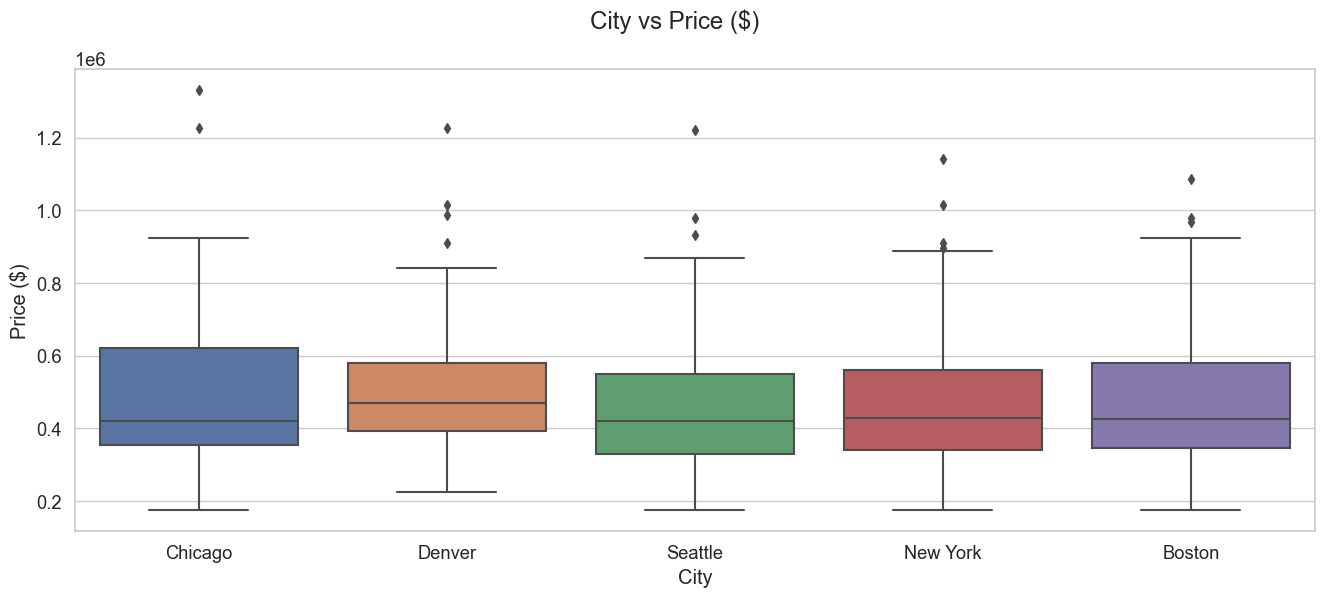

In [381]:
fig, ax = plt.subplots(1, figsize=(16, 6))
fig.suptitle('City vs Price ($)')

sns.boxplot(ax=ax, x="City", y="Price ($)", data=house_df)

plt.show()

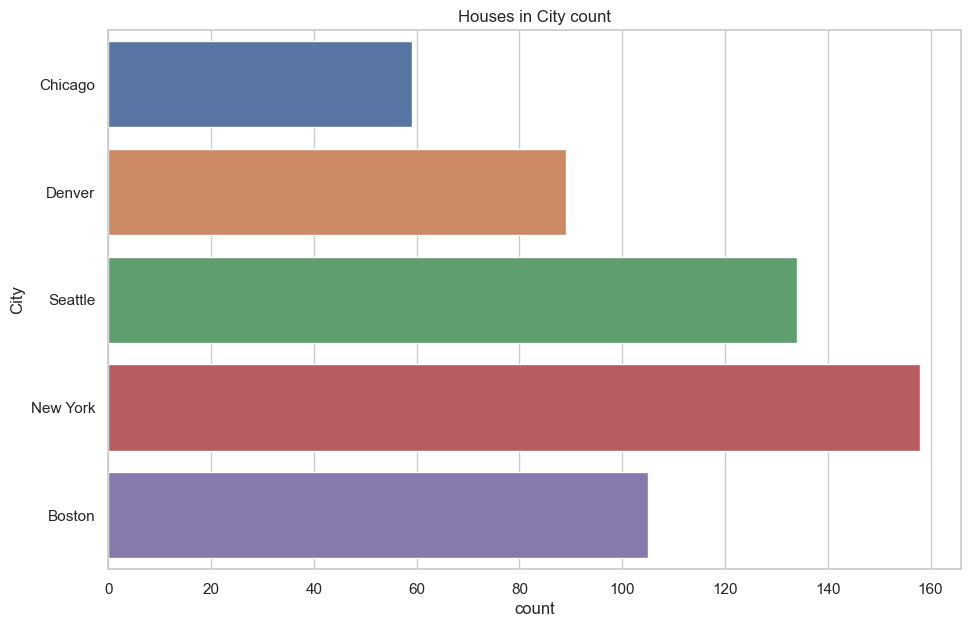

In [382]:
sns.set(rc={'figure.figsize' : (11, 7)})
sns.set_style('whitegrid')

sns.countplot(y=house_df['City'])
plt.title('Houses in City count')
plt.show()

Next, I will check the distribution of my target variable, `Price`, using a boxplot and histplot. By using both and sharing the same axes, I am able to check for outliers in the data.

Outliers in Series (First 5)


,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,1330000
1,Denver,896.0,4,4,4,furnished,1225000
2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,Seattle,750.0,4,2,2,furnished,1221500
4,New York,742.0,4,1,2,furnished,1141000


No. of Outliers: 15


<Figure size 1000x600 with 0 Axes>

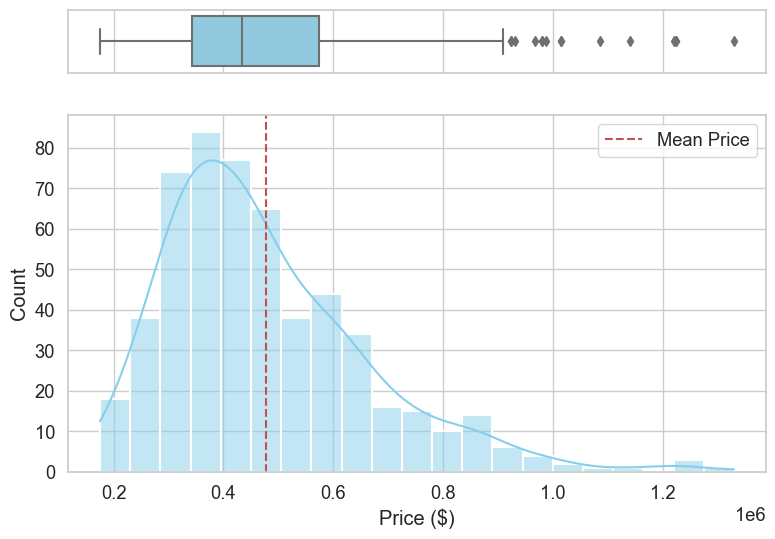

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
13,Boston,350.0,4,2,2,furnished,924000
14,Chicago,780.0,3,2,2,semi-furnished,924000
12,Seattle,655.0,4,2,2,semi-furnished,931000
11,Boston,600.0,4,3,2,semi-furnished,968100
9,Seattle,575.0,3,2,4,unfurnished,980000
10,Boston,1320.0,3,1,2,furnished,980000
8,Denver,810.0,4,1,2,furnished,987000
6,Denver,858.0,4,3,4,semi-furnished,1015000
7,New York,1620.0,5,3,2,unfurnished,1015000
5,Boston,750.0,3,3,1,semi-furnished,1085000


In [383]:
priceOutliers = outlierDetection(house_df, "Price ($)")
priceOutliers.sort_values("Price ($)")

As we can see from this heat map, all of the features have a positive correlation with other features. We can also see that House Area/Price and Toilet/Price have the highest correlation with each other.

C:\Users\Fitri\AppData\Local\Temp\ipykernel_33268\3215201319.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_matrix = house_df.corr(method='pearson')


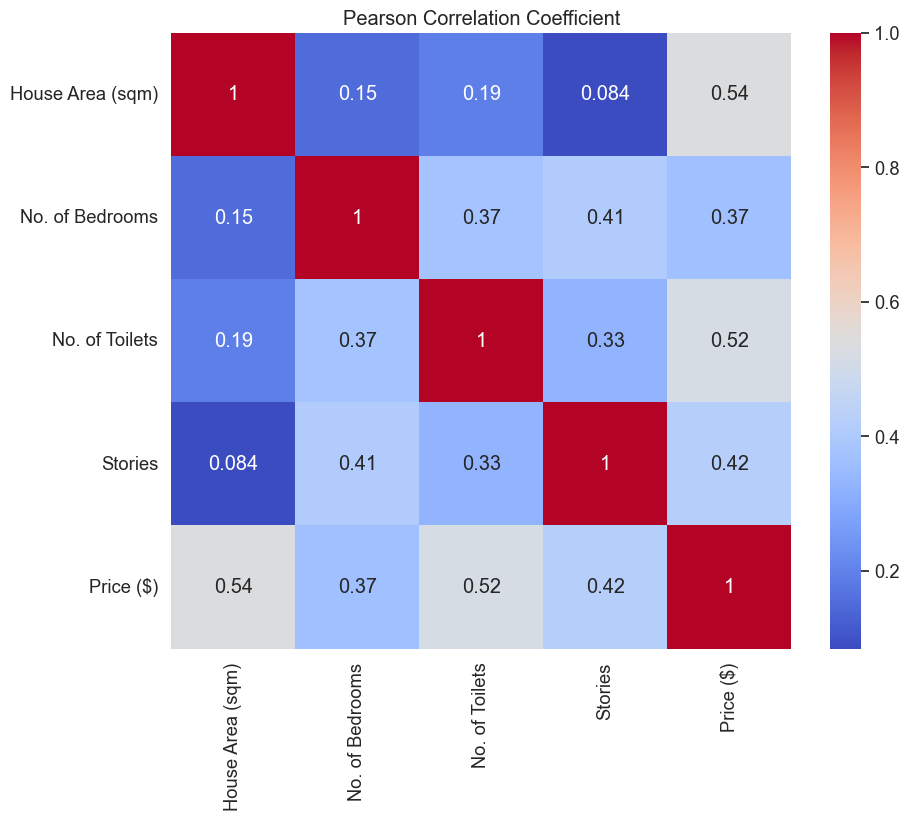

In [384]:
pearson_matrix = house_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_matrix, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Coefficient')
plt.show()

Outliers in Series (First 5)


,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
7,New York,1620.0,5,3,2,unfurnished,1015000
10,Boston,1320.0,3,1,2,furnished,980000
56,New York,1144.0,4,1,2,semi-furnished,734300
64,New York,1117.5,3,1,1,furnished,700000
66,Denver,1320.0,2,1,1,furnished,693000


No. of Outliers: 12


<Figure size 1000x600 with 0 Axes>

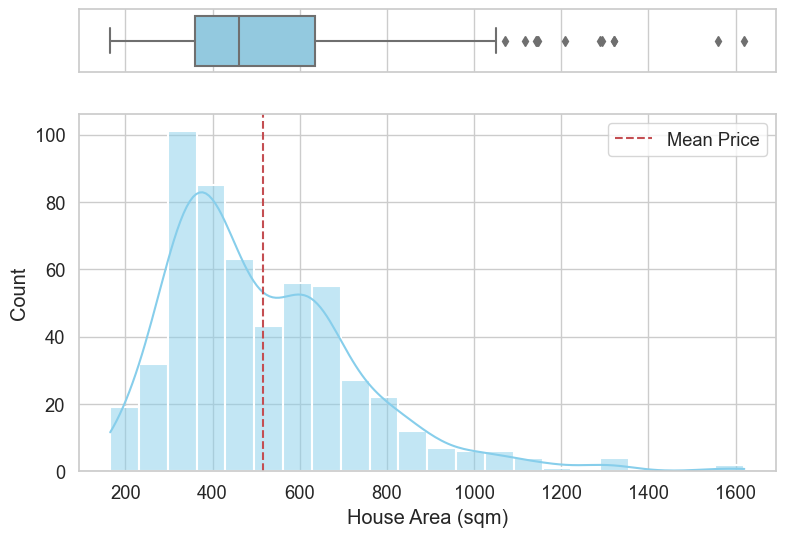

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
191,Seattle,1070.0,3,1,2,semi-furnished,504000
64,New York,1117.5,3,1,1,furnished,700000
186,New York,1141.0,2,1,2,furnished,511000
56,New York,1144.0,4,1,2,semi-furnished,734300
129,Denver,1146.0,3,1,3,semi-furnished,587300
69,Boston,1209.0,4,2,2,furnished,679000
211,Seattle,1290.0,3,1,1,furnished,490000
403,Boston,1294.4,3,1,1,unfurnished,350000
10,Boston,1320.0,3,1,2,furnished,980000
66,Denver,1320.0,2,1,1,furnished,693000


In [385]:
areaOutliers = outlierDetection(house_df, "House Area (sqm)")
areaOutliers.sort_values("House Area (sqm)")

## **Feature Engineering** 

Next, to transform my target variable `Price`, we have to look at the options given to me.

| Method | Use | 
| :----: | :---: |
| *MinMaxScaler()*|A MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data. It subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. |
| *RobustScaler()* |A RobustScaler reduce the effects of outliers, relative to MinMaxScaler. It transforms the feature vector by subtracting the median and then dividing by the interquartile range.|
| *StandardScaler()* |A StandardScaler results in a distribution with a standard deviation and variance equal to 1. It standardizes a feature by subtracting the mean and then scaling to unit variance.|
| *Normalizer()* |Normalizer works on rows instead of columns. By default, L2 normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with L2 means that if each element were squared and summed, the total would equal 1. L2, also known as ridge regression, optimizes the mean cost which is often used as a performance measurement.|
| *Log Transform* |Using a log transformation decreased the scale of the distributions, even with the huge range of the average population. The pitfalls of log transformations are that they only work on non-zero and non-negative data, and doesn’t transform to a predetermined scale (i.e. always [0–1])|

In [386]:
house_df['Price ($)'] = np.log(house_df['Price ($)'])

Outliers in Series (First 5)


,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,14.10069


No. of Outliers: 1


<Figure size 1000x600 with 0 Axes>

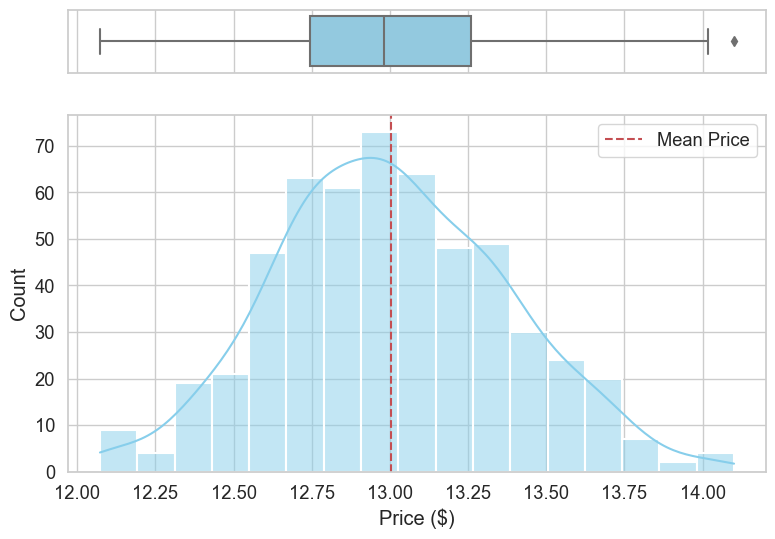

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,742.0,4,2,3,furnished,14.10069


In [387]:
priceOutliers = outlierDetection(house_df, "Price ($)")
priceOutliers.sort_values("Price ($)")

As we can see from the distribution of house prices, it is bimodal. This means that I will use log transformation in order to normalize it. By normalising my data, it makes my range of characteristics similar for all my values. Hence, it will improve the performance of my machine.

In [388]:
house_df['House Area (sqm)'] = np.log(house_df['House Area (sqm)'])

Outliers in Series (First 5)


,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
7,New York,7.390181,5,3,2,unfurnished,13.830399
125,Boston,7.352441,3,1,1,semi-furnished,13.295140


No. of Outliers: 2


<Figure size 1000x600 with 0 Axes>

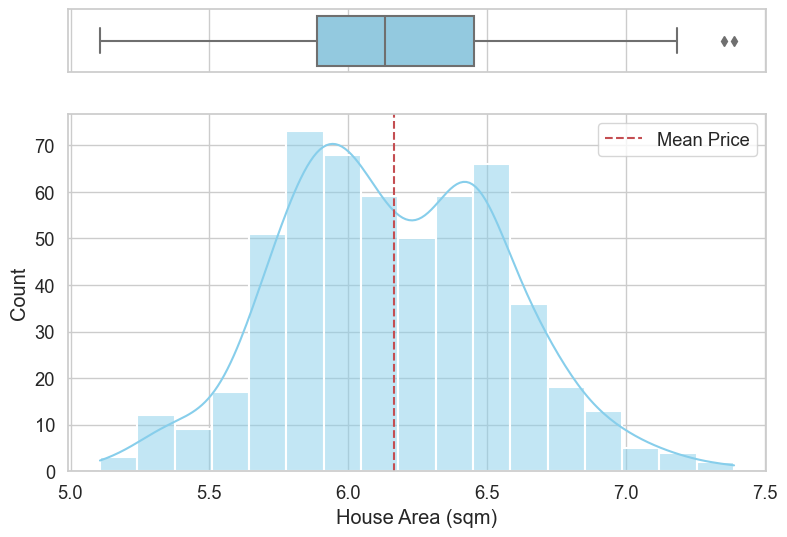

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
125,Boston,7.352441,3,1,1,semi-furnished,13.295140
7,New York,7.390181,5,3,2,unfurnished,13.830399


In [389]:
areaOutliers = outlierDetection(house_df, "House Area (sqm)")
areaOutliers.sort_values("House Area (sqm)")

As we can see, `City` and `Renovation Status`have categorical data. To use this data, I will have to encode it using 1 of 4 methods:

- pd.get_dummies()
- One Hot Encoder
- Label Encoder
- Ordinal Encoder

Firstly, `City` and `Marriage Status` is not ordinal, therefore I will have to use One Hot Encoder while `Renovation Status` is ordinal, which means I will use Ordinal/Label Encoder.

In [390]:
# create an instance of the OrdinalEncoder class
encoder = OrdinalEncoder(categories=[['unfurnished', 'semi-furnished', 'furnished']])

# fit and transform the 'Education' column
house_df['Renovation Status'] = encoder.fit_transform(house_df[['Renovation Status']])

house_df.head()

,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,Chicago,6.609349,4,2,3,2.0,14.100690
1,Denver,6.797940,4,4,4,2.0,14.018451
2,Chicago,6.903747,3,2,2,1.0,14.018451
3,Seattle,6.620073,4,2,2,2.0,14.015590
4,New York,6.609349,4,1,2,2.0,13.947416


In [391]:
# Create an instance of the OneHotEncoder class
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cities = encoder.fit_transform(house_df[['City']])

city_names = encoder.get_feature_names_out(['City'])
encoded_df = pd.DataFrame(encoded_cities, columns=city_names)

house_df = pd.concat([house_df, encoded_df], axis=1)
house_df.drop('City', axis=1, inplace=True)

house_df.head()

c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($),City_Chicago,City_Denver,City_New York,City_Seattle
0,6.609349,4,2,3,2.0,14.100690,1.0,0.0,0.0,0.0
1,6.797940,4,4,4,2.0,14.018451,0.0,1.0,0.0,0.0
2,6.903747,3,2,2,1.0,14.018451,1.0,0.0,0.0,0.0
3,6.620073,4,2,2,2.0,14.015590,0.0,0.0,0.0,1.0
4,6.609349,4,1,2,2.0,13.947416,0.0,0.0,1.0,0.0


Note that if all 4 values are 0, the location of the house is in Boston.

As we can see, the log transformation did not fix the bimodality problem, but it fixed the skewedness of the data. However, as the bimodality has not been fixed, we will need to keep that in mind as it may affect the model later on during training. There are also still 2 outliers after transforming.

Judging by the distribution and outliers of both House area and Price, we can tell that log transformation worked well. However, what do we do with the leftover outliers? Contextually, these outliers make sense; there's houses that are a lot bigger than others, and some will cost more as they are closer to more amenities/closer to city area etc. Furthermore, the dataset is not very large. I feel that I would do better off keeping these outliers in. Hence, I will be leaving the outliers in my data.

<font size = 7>

**Model Selection** 

## **Feature Selection**

Firstly, this is how my feature selection works and the ranking of importance of all the variables

In [392]:
main_df = house_df.drop(['Price ($)'], axis = 1)
target_df = house_df['Price ($)']

X = main_df
y = target_df

ridge = Ridge(alpha=1.0)  # alpha controls the regularization strength
ridge.fit(X, y)

# Get the coefficients and feature names
coefficients = ridge.coef_
feature_names = X.columns

print("Selected Features:")
for feature, coef in zip(feature_names, coefficients):
    if coef != 0:
        print(f"{feature}: {coef}")

Selected Features:
House Area (sqm): 0.4234471918935091
No. of Bedrooms: 0.04519534940137022
No. of Toilets: 0.1912196816714145
Stories: 0.09570709460577766
Renovation Status: 0.09309367989767442
City_Chicago: -0.014389361582905403
City_Denver: -0.006626725040041463
City_New York: -0.009561680998415525
City_Seattle: -0.023737155997452044


## **Train Test Split**

In [393]:
X_train, X_test, y_train, y_test = train_test_split(main_df, target_df, test_size=0.2, random_state=42)

# reset index for x_train and x_test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# reset index for y_train and y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [394]:
def create_and_evaluate_pipeline(X_train, X_test, y_train, y_test, models):
    pipelines = {}  # Dictionary to store pipelines
    scores = {}  # Dictionary to store scores
    
    for model_name, model in models.items():
        # Create a pipeline with feature selection and the current model
        pipeline = Pipeline([
            ('feature_selection', model),
            ('model', model)
        ])

        # Fit the pipeline to the training data
        pipeline.fit(X_train, y_train)

        # Evaluate the pipeline on the test data
        score = pipeline.score(X_test, y_test)

        # Store the pipeline and score
        pipelines[model_name] = pipeline
        scores[model_name] = score

    return pipelines, scores
    
def calculate_adjusted_r2(r2, n, k):
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return adjusted_r2

Next, I have to decide which scoring metrics I would like to use to score my models. I have randomly fetched a few I read about online and listed how the calculations work. In the next segment, I will also explain which metrics I have picked from this table.

| Scoring Metrics | Usage |
| :----: | :---: |
|Mean Squared Error (MSE)|Calculates the average squared difference between the predicted and actual values. It measures the average magnitude of the error, with higher values indicating larger errors.|
|Root Mean Squared Error (RMSE)|It is the square root of the MSE, which gives the measure of the average magnitude of the error in the same units as the target variable.|
|Mean Absolute Error (MAE)|Computes the average absolute difference between the predicted and actual values. It provides a measure of the average magnitude of the errors without considering their direction.|
|R-squared (R2)|Represents the proportion of the variance in the target variable that is predictable from the input variables. It indicates the goodness of fit of the model, with values closer to 1 indicating a better fit.|
|Adjusted R-squared|It adjusts the R-squared value based on the number of predictors in the model. It penalizes the addition of irrelevant variables that do not contribute much to the model's performance.|
|Mean Squared Logarithmic Error (MSLE)|Similar to MSE, but it first takes the logarithm of the predicted and actual values. It can be useful when the target variable has a wide range.|
|Explained Variance Score|Measures the proportion of the variance in the target variable that is explained by the model. It provides an alternative to R-squared.|
|Mean Absolute Percentage Error (MAPE)|MAPE calculates the average percentage difference between the true and predicted values. It is computed by taking the absolute difference between each prediction and its corresponding true value, dividing it by the true value, and averaging the results. MAPE is expressed as a percentage and provides a measure of the average relative error of the predictions.|
|Median Absolute Error (MedAE)|MedAE is the median value of the absolute differences between the true and predicted values. It provides a measure of the typical magnitude of errors in the predictions, unaffected by extreme values.|
|Mean Squared Percentage Error (MSPE)|MSPE calculates the average squared percentage difference between the true and predicted values. It is computed by squaring the percentage difference between each prediction and its corresponding true value, averaging the results, and expressing it as a percentage. MSPE gives more weight to large errors compared to MAPE.|
|Mean Percentage Error (MPE)|MPE calculates the average percentage difference between the true and predicted values, without taking the absolute value. It is computed by taking the difference between each prediction and its corresponding true value, dividing it by the true value, averaging the results, and expressing it as a percentage. MPE can be positive or negative, indicating overestimation or underestimation.|
|Mean Absolute Scaled Error (MASE)|MASE compares the mean absolute error of your model to the mean absolute error of a naive forecast. It is computed by dividing the mean absolute error of your model by the mean absolute error of a baseline model (e.g., a naive forecast that predicts the previous value). MASE provides a measure of the relative performance of your model compared to a simple baseline.|

Among these I chosee 4:

MAPE
> Provides a percentage-based measure of the average prediction error, assesses the accuracy of your model in terms of percentage deviations. It shows the average percentage deviation of your model's predictions from 

Adjusted R squared 
> Provides a measure of the model's goodness of fit while considering model complexity. Explains the variation in house prices while considering the number of predictors used.

MSE
> Useful in identifying and penalizing large prediction errors that can significantly impact the overall model performance. Represents the average deviation between the model's predictions and the actual house prices.

With these 3 scoring metrics, I am able to find the accuracy, quality of fit and prediction errors. This allows me to have maximum analysis due to the variance of data.

## **Baseline Model**

In [395]:
dummy_regr = DummyRegressor()
dummy_regr.fit(X_train, y_train)

y_pred = dummy_regr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

metrics_df = pd.DataFrame(np.array([["Dummy regressor", r2, mape, rmse]]), columns=['Model','R^2', 'MAPE', 'RMSE'])

print(metrics_df)

             Model                     R^2                  MAPE  \
0  Dummy regressor  -0.0045314344126869965  0.027994055270567923   

                 RMSE  
0  0.4404131035093082  


## **Model Selection**

In [400]:
def plot_learning_curves(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='b', label='Training')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='r', label='Validation')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='b')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='r')
    plt.xlabel('Training Examples')
    plt.ylabel('R-squared')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [399]:
from tqdm import tqdm

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the custom MAPE scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(random_state=42),
    'BayesianRidge': BayesianRidge(),
    'SVR': SVR()
}

cv5_mse_scores = []
cv5_r2_scores = []
cv5_mape_scores = []
test_mse = []
test_r2 = []
test_mape = []

for name in tqdm(models):
    model = models[name]
    model.fit(X_train, y_train)
    cv5_mse_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))
    cv5_r2_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='r2')) * 100)
    cv5_mape_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring = mape_scorer)))
    
    model.fit(X_train, y_train)  # Fit and then test baseline models on the test set
    y_pred = model.predict(X_test)

    test_mse.append(mean_squared_error(y_test, y_pred))
    test_r2.append(r2_score(y_test, y_pred))
    test_mape.append(mean_absolute_percentage_error(y_test, y_pred))

model_list = []
for index, (key, value) in enumerate(models.items()):
    model_list.append(key)

results = {
    'Model': model_list,
    '5-fold cv Negative MSE': cv5_mse_scores,
    'test_mse': test_mse,
    '5_fold cv R^2 (%)': cv5_r2_scores,
    'test_r2': test_r2,
    '5-fold cv MAPE': cv5_mape_scores,
    'test_mape': test_mape
}

results_df = pd.DataFrame(results)
results_df

 75%|███████▌  | 9/12 [00:11<00:05,  1.87s/it]c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\l

,Model,5-fold cv Negative MSE,test_mse,5_fold cv R^2 (%),test_r2,5-fold cv MAPE,test_mape
0,Linear Regression,-0.053988,0.087447,55.961546,0.547114,-1.391318,1.842382
1,K-Nearest Neighbors,-0.066446,0.119804,45.715884,0.379540,-1.512433,2.008545
2,Elastic Net,-0.125016,0.193964,-1.995466,-0.004531,-2.167798,2.799406
3,Decision Tree,-0.099113,0.140200,17.098892,0.273909,-1.887679,2.145182
4,Random Forest,-0.059761,0.092378,51.270586,0.521575,-1.456209,1.785127
5,ExtraTreesRegressor,-0.066582,0.107208,44.933862,0.444772,-1.579179,1.979364
6,AdaBoost,-0.058914,0.102033,51.401469,0.471577,-1.451749,1.975944
7,Gradient Boosting,-0.056116,0.088371,54.322548,0.542328,-1.405092,1.850366
8,HistGradientBoosting,-0.058604,0.091947,52.307082,0.523808,-1.441041,1.881934
9,MLPRegressor,-0.436473,0.306251,-273.506519,-0.586066,-4.027025,3.438981


In [402]:
from tqdm import tqdm

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

models = {
    'Linear Regression': LinearRegression(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Elastic Net': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'MLPRegressor': MLPRegressor(random_state=42),
    'BayesianRidge': BayesianRidge(),
    'SVR': SVR()
}

cv5_mse_scores = []
cv5_r2_scores = []
cv5_mape_scores = []
test_mse = []
test_r2 = []
test_mape = []

for name in tqdm(models):
    model = models[name]
    model.fit(X_train, y_train)
    
    # Calculate cross-validated predictions
    cv_preds = cross_val_predict(model, X_train, y_train, cv=5)
    
    cv5_mse_scores.append(mean_squared_error(y_train, cv_preds))
    cv5_r2_scores.append(r2_score(y_train, cv_preds) * 100)
    cv5_mape_scores.append(mean_absolute_percentage_error(y_train, cv_preds))
    
    model.fit(X_train, y_train)  # Fit the model on the entire training set
    y_pred = model.predict(X_test)

    test_mse.append(mean_squared_error(y_test, y_pred))
    test_r2.append(r2_score(y_test, y_pred))
    test_mape.append(mean_absolute_percentage_error(y_test, y_pred))

model_list = []
for index, (key, value) in enumerate(models.items()):
    model_list.append(key)

results = {
    'Model': model_list,
    '5-fold cv Negative MSE': cv5_mse_scores,
    'test_mse': test_mse,
    '5_fold cv R^2 (%)': cv5_r2_scores,
    'test_r2': test_r2,
    '5-fold cv MAPE': cv5_mape_scores,
    'test_mape': test_mape
}

results_df = pd.DataFrame(results)
results_df

 75%|███████▌  | 9/12 [00:05<00:02,  1.40it/s]c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Fitri\anaconda3\l

,Model,5-fold cv Negative MSE,test_mse,5_fold cv R^2 (%),test_r2,5-fold cv MAPE,test_mape
0,Linear Regression,0.054002,0.087447,56.578897,0.547114,1.391461,1.842382
1,K-Nearest Neighbors,0.066459,0.119804,46.562896,0.379540,1.512473,2.008545
2,Elastic Net,0.125068,0.193964,-0.562049,-0.004531,2.168200,2.799406
3,Decision Tree,0.099072,0.140200,20.340351,0.273909,1.887513,2.145182
4,Random Forest,0.059775,0.092378,51.937260,0.521575,1.456255,1.785127
5,ExtraTreesRegressor,0.066573,0.107208,46.471472,0.444772,1.578972,1.979364
6,AdaBoost,0.058921,0.102033,52.623857,0.471577,1.451755,1.975944
7,Gradient Boosting,0.056144,0.088371,54.857095,0.542328,1.405395,1.850366
8,HistGradientBoosting,0.058630,0.091947,52.857849,0.523808,1.441324,1.881934
9,MLPRegressor,0.436385,0.306251,-250.879426,-0.586066,4.026804,3.438981


Based on these observations, the three models that show promising performance are:

Linear Regression
> It demonstrates good performance in terms of R^2, test MSE, and 5-fold cv MAPE.

Gradient Boosting
> It has a high 5-fold cv R^2 score, a relatively low test MSE, and a low 5-fold cv MAPE.

Random Forest
> Although not explicitly mentioned, the model's 5-fold cv R^2 score of 51.27% and test R^2 score of 52.16% indicate reasonable performance.

  0%|          | 0/3 [00:00<?, ?it/s]

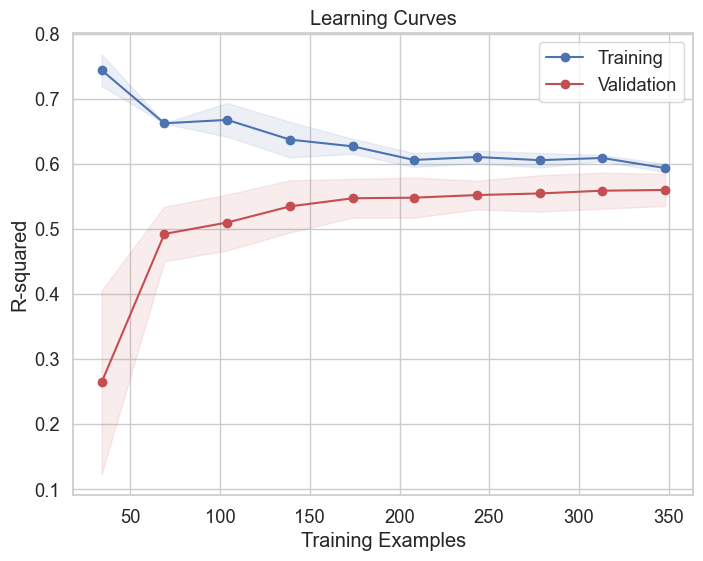

 33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]

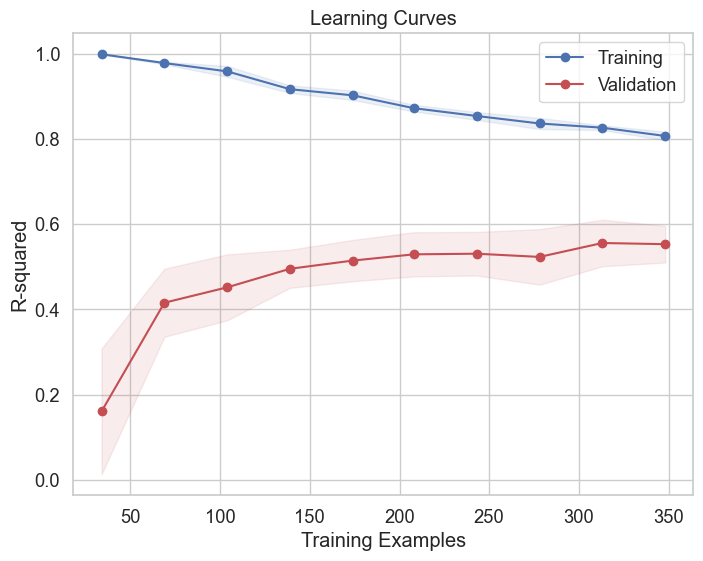

 67%|██████▋   | 2/3 [00:03<00:02,  2.04s/it]

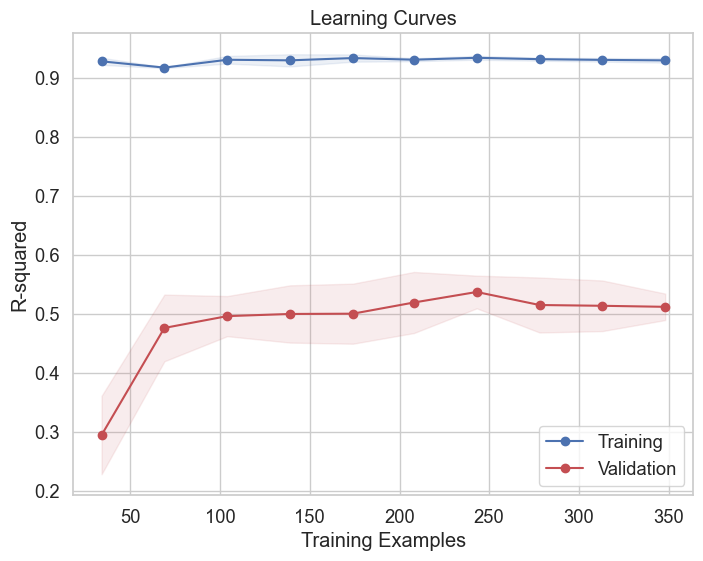

100%|██████████| 3/3 [00:11<00:00,  3.98s/it]


In [401]:
finalModels = (
    ('Linear Regression', LinearRegression()),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
)

for model in tqdm(finalModels):
    plot_learning_curves(model[1], X_train, y_train, cv=5)

<hr>

## **References**<br>

Log transform:<br>
https://towardsdatascience.com/feature-transformation-for-multiple-linear-regression-in-python-8648ddf070b8 <br>

Scaling:<br>
https://medium.com/analytics-vidhya/why-scaling-is-important-in-machine-learning-aee5781d161a <br>
https://towardsdatascience.com/regularization-avoiding-overfitting-in-machine-learning-bb65d993e9cc<br>
https://developers.google.com/machine-learning/data-prep/transform/normalization <br>

Outlier removal:<br>
https://medium.com/analytics-vidhya/how-to-remove-outliers-for-machine-learning-24620c4657e8<br>

Scoring metrics:<br>
https://machinelearningmastery.com/regression-metrics-for-machine-learning/<br>
https://scikit-learn.org/stable/modules/model_evaluation.html<br>
https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/<br>
https://medium.com/analytics-vidhya/evaluation-metrics-for-regression-algorithms-along-with-their-implementation-in-python-9ec502729dad